<a href="https://colab.research.google.com/github/JhonCastillo25/VisionComputacional/blob/main/Laboratorio_1_AdvDL_Resnet50_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.models import Model #faltaba
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense,   Activation, BatchNormalization, Add, Multiply, Input, Reshape, Conv2DTranspose
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, Lambda, Concatenate
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import regularizers, optimizers
from keras.datasets import cifar10
from tensorflow.keras.regularizers import l2
import tensorflow as tf


##CBAM

In [ ]:
input_shape = (1,2,2,3)
print(K.image_data_format())
xej = tf.random.normal(input_shape)
print("x es: ", xej)
y = MaxPooling2D()(xej)
print("el shape de y es:", y.shape)
print("y es: " , y)

maxp = Lambda (lambda x: K.max(x, axis=3, keepdims=True))(xej)
print ("maxp :", maxp)

channels_last
x es:  tf.Tensor(
[[[[ 0.7081887  -0.66319424  0.56838816]
   [-0.6337307   0.40762195  1.4401501 ]]

  [[-0.42337534 -0.38674808 -0.77927876]
   [-1.5161673   2.503075   -0.12964089]]]], shape=(1, 2, 2, 3), dtype=float32)
el shape de y es: (1, 1, 1, 3)
y es:  tf.Tensor([[[[0.7081887 2.503075  1.4401501]]]], shape=(1, 1, 1, 3), dtype=float32)
maxp : tf.Tensor(
[[[[ 0.7081887 ]
   [ 1.4401501 ]]

  [[-0.38674808]
   [ 2.503075  ]]]], shape=(1, 2, 2, 1), dtype=float32)


In [ ]:
def ch_attention(input_t, ratio=8):
  inputs = input_t
  channel_axis=1 if K.image_data_format()=='channels_first' else -1
  filters = inputs.shape[channel_axis]

  #definir la MLP compartida
  MLP_Layer_S1 = Dense(filters//ratio, activation='relu', kernel_initializer='he_normal', use_bias = True, bias_initializer='zeros')
  MLP_Layer_S2 = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias = True, bias_initializer='zeros')

  #operando el average pooling
  avg_pool = GlobalAveragePooling2D()(inputs)
  avg_pool = Reshape((1,1,filters))(avg_pool)
  avg_pool = MLP_Layer_S1(avg_pool)
  avg_pool = MLP_Layer_S2(avg_pool)

  #operando el max pooling
  max_pool = MaxPooling2D(pool_size=(inputs.shape[-3],inputs.shape[-2]),strides=(1,1))(inputs)
  max_pool = Reshape((1,1,filters))(max_pool)
  max_pool = MLP_Layer_S1(max_pool)
  max_pool = MLP_Layer_S2(max_pool)

  #sumarndo las dos operaciones
  cbam_feat_ch = Add()([avg_pool, max_pool])
  cbam_feat_ch = Activation('sigmoid')(cbam_feat_ch)
  cbam_feat_ch = Multiply()([cbam_feat_ch, inputs])
  return cbam_feat_ch


In [ ]:
def sp_attention(input_t, kz =7):
  inputs = input_t
  avg_pool = Lambda(lambda x: K.max(x,axis=3, keepdims=True))(inputs)
  max_pool = Lambda(lambda x: K.mean(x,axis=3, keepdims=True))(inputs)
  concat = Concatenate(axis =3)([avg_pool, max_pool])
  cbam_feat_sp = Conv2D(filters=1, kernel_size=kz,strides=1, padding='same', activation='sigmoid',
  kernel_initializer='he_normal', use_bias = False)(concat)
  cbam_feat_sp = Multiply()([cbam_feat_sp,inputs])
  return(cbam_feat_sp)


In [ ]:
def cbam_block(input_t):
  inputs=input_t
  cbam_feat_ch = ch_attention(inputs)
  cbam_feat = sp_attention(cbam_feat_ch)
  
  return cbam_feat


## squeeze

In [ ]:
def squeeze_excite_block(input_t, ratio=16):
  init = input_t
  channel_axis=1 if K.image_data_format()=="channel_first" else -1
  filters = init.shape[channel_axis]
  se_shape=(1,1,filters)
  se = GlobalAveragePooling2D()(init)
  se = Reshape(se_shape)(se)
  se = Dense(filters // ratio, activation='relu', 
             kernel_initializer='he_normal', use_bias=False)(se)
  se = Dense(filters, activation='sigmoid',
             kernel_initializer='he_normal',use_bias=False)(se)
  x = Multiply()([init, se])     
  return x      


##Resnet50

In [ ]:
def initial_block_conv(Input, filters,kz=7,stride=1):
  x = Conv2D(filters,kernel_size=(kz,kz),strides=(stride,stride), padding='same', use_bias =False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [ ]:
def conv_block(Input,filters,stride=1):
  #Bloque 1x1
  x = Conv2D(filters,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 3x3
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 1x1
  x = Conv2D(filters*4,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x)
  x = BatchNormalization()(x)
  #x = Activation(x)

  #Shortcut
  skip_conv = Conv2D(filters*4,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(Input)
  skip_conv= BatchNormalization()(skip_conv)
  
  #sumar 
  x = Add()([x,skip_conv])
  return x


In [ ]:
def ident_block(Input,filters,sqex,cbam,stride=1):
  #Bloque 1x1
  x = Conv2D(filters,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 3x3
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 1x1
  x = Conv2D(filters*4,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x) #ojo con la dimenrsion
  x = BatchNormalization()(x)
  #x = Activation(x)
  if sqex == True:
    x= squeeze_excite_block(x,16)

  if cbam == True:
    x= cbam_block(x)
  
    
  #sumar 
  x = Add()([x,Input])
  return x

In [ ]:
def ResNet50(h,w,n_outputs,r1,r2,r3,r4,sqex,cbam,first_kernel_size=7, first_stride=1):
  inputs = Input(shape=(h,w,3))

#se activo el pre stem para aumentar el tamaño de las imagenes de entrada al modelo'''

  #pre-stem (usted puede descomentar esta parte si desea usar pre-stem con el fin de aumentar el tamaño de la imagen de entrada )
  # deconvolucion1, toma la imagen de CIFAR (32, 32, 3) and se obtiene una imagen de  (64, 64, 3)
  x = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu')(inputs)
  x = (BatchNormalization())(x)
  #deconvolucion2, se obtiene una imagen de  (128, 128, 3) la cual será la entrada a la ResNet50
  #x = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu')(x)
  #x = (BatchNormalization())(x)
  
  
  #Stage 1
  x = initial_block_conv(x,64,first_kernel_size, first_stride)
  
  #x = initial_block_conv(inputs,64,first_kernel_size, first_stride)
  x = MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)
  
  #Stage 2
  x = conv_block(x,64,1)
  x = Activation('relu')(x)
  for i in range(r1-1):
    
    x = ident_block(x,64,sqex,cbam,1)
    x = Activation('relu')(x)

  #Stage 3
  x = conv_block(x,128,1)
  x = Activation('relu')(x)
  for i in range(r2-1):
    x = ident_block(x,128,sqex,cbam,1)
    x = Activation('relu')(x)
  
  #Stage 4
  x = conv_block(x,256,1)
  x = Activation('relu')(x)
  for i in range(r3-1):
    x = ident_block(x,256,sqex,cbam,1)
    x = Activation('relu')(x)

  #Stage 5
  x = conv_block(x,512,1)
  x = Activation('relu')(x)
  for i in range(r4-1):
    x = ident_block(x,512,sqex,cbam,1)
    x = Activation('relu')(x)

  x_shape = K.int_shape(x)
  x = AveragePooling2D(pool_size=(x_shape[1],x_shape[2]),strides=(1,1))(x) #Ojo con el shape
  x = Flatten()(x)
  x = Dense(1000,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(x)
  x = Dense(n_outputs,activation='softmax')(x)
  modelo = Model(inputs=inputs, outputs=x)
  return modelo

  

In [ ]:
mod_RN_cbamN =ResNet50(32,32,10,3,4,6,3,False,True,7,1)
mod_RN_cbamN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 3)   84          ['input_1[0][0]']                
 ose)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 3)   12          ['conv2d_transpose[0][0]']       
 alization)                                                                                       
                                                                                              

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(mod_RN_cbamN,"ResNet50_cbam.png", show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.978265 to fit



##Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.preprocessing.image import array_to_img

In [ ]:
(x_train,y_train),(x_test,y_test)= cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


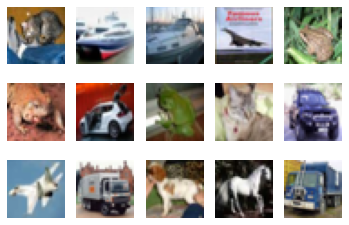

In [ ]:
for i in range(0,15):
  plt.subplot(3,5,i+1)
  plt.axis('off')
  plt.imshow(array_to_img(x_test[i]))
plt.show()

In [ ]:
x_train=x_train.astype('float32')/255.0
x_test =x_test.astype('float32')/255.0

In [ ]:
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test_mean = np.mean(x_test, axis=0)
x_test -= x_test_mean

print(y_train.shape, y_test.shape)

(50000, 1) (10000, 1)


In [ ]:
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
from keras.utils import np_utils

In [ ]:
#one hot encoding
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)


In [ ]:
#Crear una revisión de si existen ya pesos, cargarlos al modelo


In [ ]:
#Realizar un Schedule para el learning rate y un checkpoint para salvar los pesos
#Existen diferente maneras de reducir el LR esta es una de ellas
# LR = initial_LR *drop **((1+epoch)/epochs_drop)
import math
def paso_deca(epoch):
  initial_LR = 0.1
  drop = 0.7
  epochs_drop = 7
  LRate = initial_LR * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return LRate


In [ ]:
from keras.callbacks import LearningRateScheduler, EarlyStopping
LRate = LearningRateScheduler(paso_deca)

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/MyDrive/Modelos/M.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
early_stopping=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5,restore_best_weights=True)
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
optimiz = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
mod_RN_cbamN.compile(loss='categorical_crossentropy', optimizer=optimiz, metrics=['accuracy'])

In [ ]:
batch_size=16 #64
epochs=20
history = mod_RN_cbamN.fit(x_train,y_train, batch_size=batch_size*1,epochs=epochs,validation_data=(x_test,y_test), shuffle=True, verbose=1, callbacks=[checkpoint, early_stopping])

Epoch 1/20
  47/3125 [..............................] - ETA: 24:32 - loss: 3.0473 - accuracy: 0.2008

KeyboardInterrupt: ignored

In [ ]:
#graficar la perdida  a traves de las epocas
plt.plot(history.history["loss"],'b',label="Loss entrenamiento")
plt.plot(history.history["val_loss"],'r', label = "Loss_validacion")
plt.title("Loss Resnet50 con squeeze ")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
#graficar el accuracy  a traves de las epocas
plt.plot(history.history["accuracy"],'b',label="Accuracy entrenamiento")
plt.plot(history.history["val_accuracy"],'r', label = "Accuracy validacion")
plt.title("Accuracy Resnet50 con squeeze")
plt.legend()
plt.show()

Cargar un modelo y seguir entrenando

In [ ]:
mod_RN_cbamN.load_weights('/content/gdrive/MyDrive/Modelos/M.hdf5')

In [ ]:
history2 = mod_RN_cbamN.fit(x_train,y_train, batch_size=batch_size*1,epochs=20,validation_data=(x_test,y_test), shuffle=True, verbose=1, callbacks=[checkpoint, early_stopping], initial_epoch=10)

Epoch 11/20
3125/3125 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9436
Epoch 11: val_accuracy improved from -inf to 0.84050, saving model to /content/gdrive/MyDrive/Modelos/M.hdf5
3125/3125 [==============================] - 1582s 506ms/step - loss: 0.1795 - accuracy: 0.9436 - val_loss: 0.5698 - val_accuracy: 0.8405
Epoch 12/20
3125/3125 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9403
Epoch 12: val_accuracy did not improve from 0.84050
3125/3125 [==============================] - 1580s 506ms/step - loss: 0.1858 - accuracy: 0.9403 - val_loss: 0.6591 - val_accuracy: 0.8264
Epoch 13/20
3125/3125 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9429
Epoch 13: val_accuracy did not improve from 0.84050
3125/3125 [==============================] - 1580s 506ms/step - loss: 0.1798 - accuracy: 0.9429 - val_loss: 0.6109 - val_accuracy: 0.8260
Epoch 14/20
3125/3125 [==============================] - ETA: 0s - loss: 0.1

In [ ]:
#graficar la perdida  a traves de las epocas
plt.plot(history2.history["loss"],'b')
plt.title("Loss Resnet50 10 epocas")
plt.show()

In [ ]:
#graficar loss para las 20 epocas

loss_a=history.history["loss"]
loss_b=history2.history["loss"]

val_loss_a=history.history["val_loss"]
val_loss_b=history2.history["val_loss"]

loss_a=np.array(loss_a)
loss_b=np.array(loss_b)
val_loss_a=np.array(val_loss_a)
val_loss_b=np.array(val_loss_b)

loss_Total =np.concatenate((loss_a,loss_b),axis=0)
val_loss_Total = np.concatenate((val_loss_a,val_loss_b),axis=0)

plt.plot(loss_Total,'b',label= "Loss entrenamiento")
plt.plot(val_loss_Total,'r',label= "Loss validacion")
plt.title("Loss Resnet50 20 epocas")
plt.legend()
plt.show()

In [ ]:
#graficar loss para las 20 epocas

acc_a=history.history["accuracy"]
acc_b=history2.history["accuracy"]

val_acc_a=history.history["val_accuracy"]
val_acc_b=history2.history["val_accuracy"]

acc_a=np.array(acc_a)
acc_b=np.array(acc_b)
val_acc_a=np.array(val_acc_a)
val_acc_b=np.array(val_acc_b)

acc_Total =np.concatenate((acc_a,acc_b),axis=0)
val_acc_Total = np.concatenate((val_acc_a,val_acc_b),axis=0)

plt.plot(acc_Total,'b',label= "accuracy entrenamiento")
plt.plot(val_acc_Total,'r',label= "accuracy validacion")
plt.title("Accuracy Resnet50 20 epocas")
plt.legend()
plt.show()

In [ ]:
!nvidia-smi